In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
data = pd.read_csv("greatlakedata/ontario1918.csv", header = 2, index_col = 0) #read data
data = data.drop([2021, 2022]) #drop years with nan values
a = data.unstack().values #unstack 2d data into one long 1d list

In [8]:
data_average = np.mean(a) #standardization
data_deviation = np.std(a)
for i in range(len(a)):
    a[i] -= data_average
    a[i] /= data_deviation

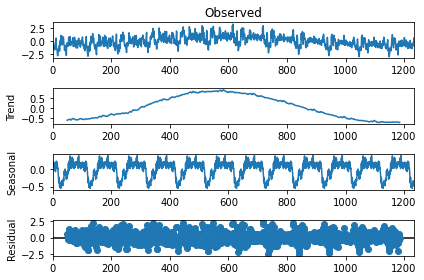

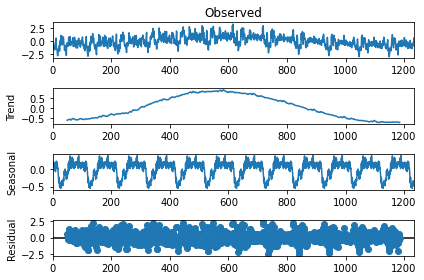

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(a, model='additive', period = 100) 
result.plot()

In [10]:
from sklearn.model_selection import train_test_split
a = result.trend[np.logical_not(np.isnan(result.trend))]
a
x = []
y = []
print(a.size)
for i in range(len(a)-24):
    x.append(a[i:i+24])
    y.append(a[i+24])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, shuffle = True)
y_test


1136


[-0.007603146125256383,
 -0.1634192720559077,
 -0.20731927417168164,
 0.866353474942682,
 0.6523409646282945,
 0.2640281169660853,
 0.7134255070459631,
 0.23557976033185152,
 0.3934175968862569,
 -0.6275462681088407,
 0.14041495311377783,
 -0.5531761987350828,
 0.8280853809930775,
 -0.2737469089521248,
 -0.6897860737400849,
 -0.3030617129965382,
 0.3320442386651938,
 -0.2759130274775748,
 0.6082965546108241,
 -0.12110775685879839,
 0.5853356982410636,
 0.5947222118513438,
 -0.24269921008735154,
 0.7807195892365866,
 -0.6923854159706241,
 -0.4522350754491469,
 -0.6460304795260079,
 0.21810640422655847,
 -0.5435008693214098,
 -0.6884864026248159,
 -0.6240804784681223,
 0.5125541157859642,
 -0.5401794875823875,
 0.6419435957061378,
 0.7694557729042494,
 0.36857943779443547,
 0.07095475239770438,
 -0.38927323030942096,
 -0.26147223730791175,
 0.42562055896460343,
 0.6907534664795946,
 0.43183009873755857,
 -0.05395808256987146,
 0.3591929241841584,
 0.005104749224046018,
 -0.59895350357291

In [11]:
from torch.utils.data import DataLoader,Dataset
class Pd(Dataset):
    def __init__(self, x, y):
        self.input = x
        self.target = y
    def __getitem__(self, index):
        inputs = self.input[index]
        target = self.target[index]
        return inputs, target
    def __len__(self):
        return len(self.input)
    
train_dataset = Pd(x_train, y_train)
train_dataLoader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

test_dataset = Pd(x_test, y_test)
test_dataLoader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [13]:
import torch as tr
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, input_size):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size = input_size,
            hidden_size = 64, #number of features coming out of the LSTM layer
            num_layers = 1, #number of LSTM layers
            #batch_first = True,
        )
        self.out = nn.Sequential(
            nn.Dropout(0.5),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(1),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(32, 1),
        )
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None) #initial h and c is 0
        out = self.out(r_out)
        return out

model = RNN(24)
model = tr.load("Ontario/sens_ontario.pt")
loss_function = nn.MSELoss()
op = tr.optim.Adam(model.parameters(), lr=0.001)
op_2 = tr.optim.Adam(model.parameters(), lr = 0.0001)

FileNotFoundError: [Errno 2] No such file or directory: 'Ontario/sens_ontario.pt'

In [ ]:
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
model = model.to(device)
all_loss = []
epochs = 70
last_pred = []
last_y = []
for i in range(epochs):
    model.train()
    if i > 200:
        op = op_2
    for index_train, data in enumerate(train_dataLoader):
        x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
        y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
        op.zero_grad()
        pred = model(x)
        loss_train = loss_function(tr.squeeze(pred), tr.squeeze(y))
        loss_train.backward()
        op.step()
    model.eval()
    for index_test, data in enumerate(test_dataLoader):
        x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
        y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
        op.zero_grad()
        pred = model(x)
        if i%20 == 0:
            print(tr.squeeze(pred))
        if i == epochs - 1:
            last_y.append(tr.squeeze(y).tolist())
            last_pred.append(tr.squeeze(pred).tolist())
        loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
        op.step()
    print ("Epoch %d, Loss Train: %f, Loss Test: %f"%(i, loss_train, loss_test))

tensor([0.1546, 0.1769, 0.2216, 0.2100, 0.2300, 0.2199, 0.2376, 0.2194, 0.2270,
        0.2131, 0.2218, 0.2098, 0.2244, 0.2111, 0.2095, 0.2054, 0.2100, 0.2317,
        0.2293, 0.2311, 0.2351, 0.2431, 0.2224, 0.2250, 0.2190, 0.2101, 0.2214,
        0.2146, 0.2082, 0.2247, 0.2140, 0.2188], grad_fn=<SqueezeBackward0>)
tensor([0.1641, 0.2212, 0.2179, 0.2160, 0.2389, 0.2371, 0.2265, 0.2447, 0.2308,
        0.2291, 0.2414, 0.2286, 0.2288, 0.2332, 0.2453, 0.2405, 0.2344, 0.2455,
        0.2328, 0.2431, 0.2362, 0.2255, 0.2237, 0.2425, 0.2362, 0.2240, 0.2213,
        0.2407, 0.2364, 0.2475, 0.2301, 0.2453], grad_fn=<SqueezeBackward0>)
tensor([0.1612, 0.2228, 0.2330, 0.2279, 0.2370, 0.2341, 0.2495, 0.2428, 0.2406,
        0.2356, 0.2509, 0.2540, 0.2569, 0.2568, 0.2387, 0.2292, 0.2353, 0.2258,
        0.2301, 0.2319, 0.2433, 0.2543, 0.2607, 0.2382, 0.2272, 0.2441, 0.2404,
        0.2324, 0.2257, 0.2320, 0.2315, 0.2461], grad_fn=<SqueezeBackward0>)
tensor([0.1630, 0.2112, 0.2255, 0.2288, 0.2467, 0

Epoch 30, Loss Train: 0.006183, Loss Test: 0.001960
Epoch 31, Loss Train: 0.003974, Loss Test: 0.000636
Epoch 32, Loss Train: 0.002698, Loss Test: 0.001282
Epoch 33, Loss Train: 0.001237, Loss Test: 0.000615
Epoch 34, Loss Train: 0.003055, Loss Test: 0.000622
Epoch 35, Loss Train: 0.004089, Loss Test: 0.002808
Epoch 36, Loss Train: 0.001467, Loss Test: 0.000534
Epoch 37, Loss Train: 0.001639, Loss Test: 0.000972
Epoch 38, Loss Train: 0.001886, Loss Test: 0.001616
Epoch 39, Loss Train: 0.003547, Loss Test: 0.000786
tensor([0.4398, 0.4035, 0.5805, 0.3974, 0.5409, 0.4090, 0.5907, 0.3973, 0.4947,
        0.3970, 0.4765, 0.3966, 0.5102, 0.3972, 0.4101, 0.4002, 0.4254, 0.5846,
        0.4696, 0.4943, 0.5270, 0.5837, 0.3994, 0.4665, 0.4209, 0.4014, 0.4868,
        0.4127, 0.4008, 0.5227, 0.4039, 0.4485], grad_fn=<SqueezeBackward0>)
tensor([0.4566, 0.5981, 0.4102, 0.4006, 0.5623, 0.4588, 0.4056, 0.5850, 0.4084,
        0.4337, 0.5479, 0.4072, 0.4399, 0.4761, 0.5666, 0.4684, 0.4418, 0.5638,
   

Epoch 61, Loss Train: 0.002211, Loss Test: 0.000995
Epoch 62, Loss Train: 0.001541, Loss Test: 0.000570
Epoch 63, Loss Train: 0.001304, Loss Test: 0.001199
Epoch 64, Loss Train: 0.001920, Loss Test: 0.000538
Epoch 65, Loss Train: 0.000708, Loss Test: 0.000325
Epoch 66, Loss Train: 0.000715, Loss Test: 0.000233
Epoch 67, Loss Train: 0.001711, Loss Test: 0.000178
Epoch 68, Loss Train: 0.000824, Loss Test: 0.000387
Epoch 69, Loss Train: 0.000780, Loss Test: 0.000417
Epoch 70, Loss Train: 0.000816, Loss Test: 0.000546
Epoch 71, Loss Train: 0.001151, Loss Test: 0.001189
Epoch 72, Loss Train: 0.001076, Loss Test: 0.000413
Epoch 73, Loss Train: 0.000963, Loss Test: 0.000271
Epoch 74, Loss Train: 0.000544, Loss Test: 0.001111
Epoch 75, Loss Train: 0.001334, Loss Test: 0.000214
Epoch 76, Loss Train: 0.001276, Loss Test: 0.000196
Epoch 77, Loss Train: 0.002669, Loss Test: 0.000725
Epoch 78, Loss Train: 0.001405, Loss Test: 0.000646
Epoch 79, Loss Train: 0.001214, Loss Test: 0.000244
tensor([0.42

Epoch 101, Loss Train: 0.000942, Loss Test: 0.000118
Epoch 102, Loss Train: 0.001274, Loss Test: 0.000290
Epoch 103, Loss Train: 0.001588, Loss Test: 0.000426
Epoch 104, Loss Train: 0.001363, Loss Test: 0.000311
Epoch 105, Loss Train: 0.000853, Loss Test: 0.000326
Epoch 106, Loss Train: 0.001707, Loss Test: 0.000452
Epoch 107, Loss Train: 0.000836, Loss Test: 0.000150
Epoch 108, Loss Train: 0.001108, Loss Test: 0.000232
Epoch 109, Loss Train: 0.000334, Loss Test: 0.000126
Epoch 110, Loss Train: 0.000697, Loss Test: 0.000621
Epoch 111, Loss Train: 0.002259, Loss Test: 0.000254
Epoch 112, Loss Train: 0.001082, Loss Test: 0.000129
Epoch 113, Loss Train: 0.001353, Loss Test: 0.000359
Epoch 114, Loss Train: 0.001558, Loss Test: 0.000304
Epoch 115, Loss Train: 0.001929, Loss Test: 0.000241
Epoch 116, Loss Train: 0.001118, Loss Test: 0.000370
Epoch 117, Loss Train: 0.002150, Loss Test: 0.000530
Epoch 118, Loss Train: 0.001447, Loss Test: 0.000806
Epoch 119, Loss Train: 0.000312, Loss Test: 0.

Epoch 141, Loss Train: 0.001108, Loss Test: 0.000491
Epoch 142, Loss Train: 0.000420, Loss Test: 0.000661
Epoch 143, Loss Train: 0.000644, Loss Test: 0.000453
Epoch 144, Loss Train: 0.000990, Loss Test: 0.000791
Epoch 145, Loss Train: 0.001181, Loss Test: 0.001651
Epoch 146, Loss Train: 0.000624, Loss Test: 0.000274
Epoch 147, Loss Train: 0.001302, Loss Test: 0.000372
Epoch 148, Loss Train: 0.001427, Loss Test: 0.002220
Epoch 149, Loss Train: 0.000836, Loss Test: 0.000515
Epoch 150, Loss Train: 0.002028, Loss Test: 0.000393
Epoch 151, Loss Train: 0.000782, Loss Test: 0.000214
Epoch 152, Loss Train: 0.000917, Loss Test: 0.000565
Epoch 153, Loss Train: 0.000519, Loss Test: 0.000367
Epoch 154, Loss Train: 0.001078, Loss Test: 0.000951
Epoch 155, Loss Train: 0.001790, Loss Test: 0.000416
Epoch 156, Loss Train: 0.002280, Loss Test: 0.000686
Epoch 157, Loss Train: 0.000773, Loss Test: 0.000205
Epoch 158, Loss Train: 0.000613, Loss Test: 0.000791
Epoch 159, Loss Train: 0.000733, Loss Test: 0.

Epoch 181, Loss Train: 0.000739, Loss Test: 0.000098
Epoch 182, Loss Train: 0.001620, Loss Test: 0.001285
Epoch 183, Loss Train: 0.000455, Loss Test: 0.001236
Epoch 184, Loss Train: 0.000999, Loss Test: 0.000098
Epoch 185, Loss Train: 0.000669, Loss Test: 0.000417
Epoch 186, Loss Train: 0.001154, Loss Test: 0.000164
Epoch 187, Loss Train: 0.000981, Loss Test: 0.000177
Epoch 188, Loss Train: 0.000564, Loss Test: 0.000212
Epoch 189, Loss Train: 0.000599, Loss Test: 0.001487
Epoch 190, Loss Train: 0.001355, Loss Test: 0.000256
Epoch 191, Loss Train: 0.000354, Loss Test: 0.000265
Epoch 192, Loss Train: 0.000599, Loss Test: 0.000144
Epoch 193, Loss Train: 0.000976, Loss Test: 0.000672
Epoch 194, Loss Train: 0.000807, Loss Test: 0.000389
Epoch 195, Loss Train: 0.000513, Loss Test: 0.000070
Epoch 196, Loss Train: 0.000259, Loss Test: 0.000150
Epoch 197, Loss Train: 0.000752, Loss Test: 0.000080
Epoch 198, Loss Train: 0.000511, Loss Test: 0.000764
Epoch 199, Loss Train: 0.000182, Loss Test: 0.

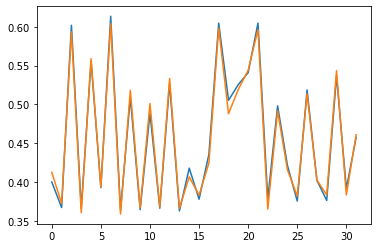

In [ ]:
plt.plot(last_y[0])
plt.plot(last_pred[0])

In [ ]:
predict

[72.65737915039062,
 72.5741958618164,
 72.55990600585938,
 72.55790710449219,
 72.55763244628906,
 72.5575942993164,
 72.55758666992188,
 72.55758666992188,
 72.55758666992188,
 72.55758666992188,
 72.55758666992188,
 72.55758666992188,
 72.55758666992188,
 72.55758666992188]